# Toxic Comment Classification - Part 1 - EDA and Feature Engineering

In [ ]:
# Installing dependencies
!pip install contractions

     |████████████████████████████████| 106 kB 12.4 MB/s 
     |████████████████████████████████| 284 kB 55.1 MB/s 


In [ ]:
# Importing packages 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import contractions
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from collections import Counter
import random
import pickle
from tqdm import tqdm
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.utils import resample

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Loading the data-set and EDA

In [ ]:
df = pd.read_csv('path/to/train.csv')
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
# Computing comment lengths

comment_lengths = []
for comment in df.comment_text.values:
  comment_lengths.append(len(comment.split()))

df['comment_lengths'] = comment_lengths
df.comment_lengths.describe()

count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: comment_lengths, dtype: float64

In [ ]:
# Combinine all the toxic categories into only 2 classes either Toxic -> 1 or Non-Toxic -> 0

df['toxic_or_not'] = df.iloc[:, 2] + df.iloc[:, 3] + df.iloc[:, 4] + df.iloc[:, 5] + df.iloc[:, 6] + df.iloc[:, 7]
df.iloc[df['toxic_or_not'] != 0, -1] = 1
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,toxic_or_not
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


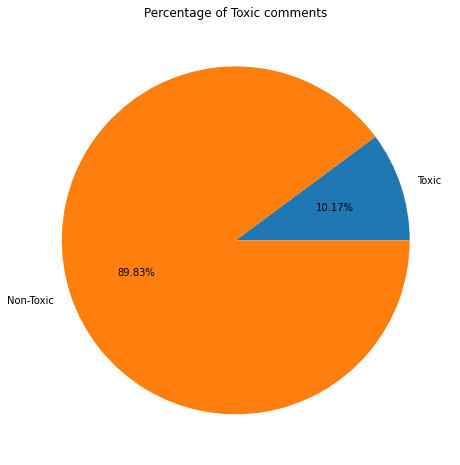

In [ ]:
# Percentage of toxic comments

plt.figure(figsize=(10, 8))
total_toxic_comments = sum(df.toxic_or_not.values)
plt.pie([total_toxic_comments, df.shape[0] - total_toxic_comments],
        labels=['Toxic', 'Non-Toxic'], autopct='%.2f%%')
plt.title('Percentage of Toxic comments')
plt.show()

Above pie chart indicates that the data is highly imbalanced.

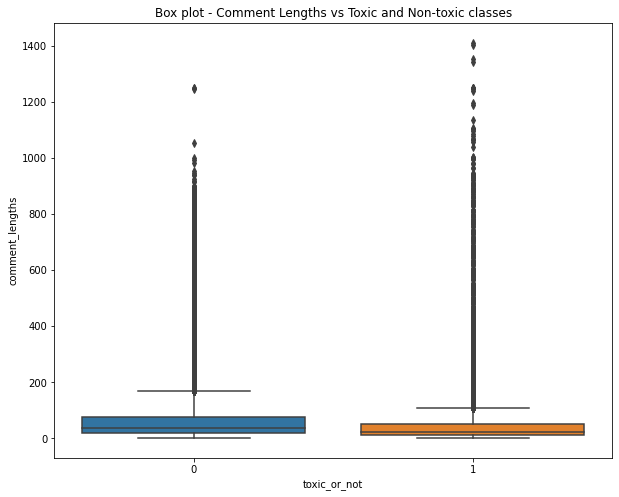

In [ ]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='toxic_or_not', y='comment_lengths', data=df)
plt.title('Box plot - Comment Lengths vs Toxic and Non-toxic classes')
plt.show()

Thus, comment lengths is not a differenciating factor among toxic and non-toxic comments and can be ignored.

## Data Cleaning - cleaning the comment text

In [ ]:
# Removing all non-alphabetical characters

cleaned_text = []
for i in range(df.shape[0]):
  text = df.comment_text.values[i].lower()
  text = re.sub(r'[^a-zA-Z\']', ' ', text)
  text = re.sub(r'^\s+|\s+$', '', text)
  cleaned_text.append(text)


# Replacing contraction terms

decontracted_text = []
for text in cleaned_text:
  decontracted_words = []
  for word in text.split():
    decontracted_words.append(contractions.fix(word).lower())
  decontracted_text.append(re.sub(r'\'', "", " ".join(decontracted_words)))


## NOTE: This part is commented out because Lemmatization 
##       did not show any significant improvement in model performance
'''
# Lemmatization
wnl = WordNetLemmatizer()
lemmatized_text = []
for text in decontracted_text:
  lt = ""
  for word in text.split():
    w1 = wnl.lemmatize(word, pos='n') # for nouns
    w2 = wnl.lemmatize(w1, pos='v') # for verbs
    w3 = wnl.lemmatize(w2, pos='a') # for adjectives
    w4 = wnl.lemmatize(w3, pos='r') # for adverbs
    w5 = wnl.lemmatize(w4, pos='s') # for satellite adjectives
    lt += " " + w5
  lemmatized_text.append(lt.strip())
'''


# Removing stop words and words less than 3 characters long

preprocessed_text = []
tokenized_text = [word_tokenize(text) for text in decontracted_text]

for text in tokenized_text:
  filtered_words = [word for word in text if word not in set(stopwords.words('english')) and len(word) > 2]
  preprocessed_text.append(filtered_words)

preprocessed_comments = [" ".join(comment).strip() for comment in preprocessed_text]

df['preprocessed_comments'] = preprocessed_comments

X = df.drop(labels=['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate', 'toxic_or_not'], axis=1)
print(X.head())
y = df.toxic_or_not

                               preprocessed_comments
0  explanation edits made username hardcore metal...
1  daww matches background colour seemingly stuck...
2  hey man really trying edit war guy constantly ...
3  make real suggestions improvement wondered sec...
4                      sir hero chance remember page


## Feature Engineering

### Loading glove vectors

In [ ]:
glove_input_file = 'path/to/glove.6B.300d.txt'
word2vec_output_file = 'path/to/glove.6B.300d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

In [ ]:
# load the Stanford GloVe model

filename = 'path/to/glove.6B.300d.txt.word2vec'
model = KeyedVectors.load_word2vec_format(filename, binary=False)
# calculate: (king - man) + woman = ?
result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
print(result)

[('queen', 0.6978678703308105)]


### Converting text into 300 dimensional vectors

In [ ]:
vectorized_text = np.empty((len(X.preprocessed_comments), 300))
for sent in tqdm(X.preprocessed_comments.values):
  sent_vec = np.zeros(300)
  #numw = 0
  for w in sent.split():
    try:
      sent_vec = np.add(sent_vec, model[w])
      #numw+=1
    except:
      pass
    vectorized_text[list(X.preprocessed_comments.values).index(sent)] = sent_vec / (np.sqrt(sent_vec.dot(sent_vec)) + 0.0001)

vectorized_text.shape

In [ ]:
vdf = np.hstack((vectorized_text, y.values.reshape(-1, 1)))
vdf = pd.DataFrame(vdf, columns=list(range(301)))

### Upsampling the minority class data

Upsampling the minority class to balance the data-set.

In [ ]:
n_samp = int(len(vectorized_df[:, -1]) - vectorized_df[:, -1].sum())
upsampled = resample(vdf.iloc[(vdf.iloc[:, -1] == 1).values, :], replace=True, n_samples=n_samp, random_state=24)
upsampled.head()

In [ ]:
# Combining the original and upsampled data-set

vdf = pd.concat([vdf, upsampled])
y = vdf.iloc[:, -1].values
X = vdf.iloc[:, :-1].values
print(X.shape)

# Saving the vectorized data for model training
#vdf.to_csv("path/to/final_vectorized_df_v4.csv", index=False)

In [ ]:
vdf.head()